In [1]:
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import numpy as np
import random
from SoccerWorld import player, game

In [7]:
def foe_action(qtable, player_state, rand_rate, num_actions, pi):

    if np.random.rand() < rand_rate:
        action = np.random.randint(0, num_actions)
    else:
#         print (np.sum(pi))
        action = random.choices([0,1,2,3,4], weights=pi)[0]

    return action


def lp(qtable, state):
    num_actions = 5
    c = matrix([0., 0., 0., 0., 0., -1.])
    
    G = qtable[state, :, :]
    G = np.hstack((G, np.ones((num_actions, 1)) * -1.))
    G = -G
    q = np.ones(num_actions+1) * 1.
    q[-1] = 0
    G = np.vstack((G, q))
    q = np.ones(num_actions+1) * -1.
    q[-1] = 0
    G = np.vstack((G, q))
    q = np.hstack((np.eye(num_actions)*-1., np.zeros((num_actions,1))))
    G = np.vstack((G,q))
    G = matrix(G)
    c = np.zeros((num_actions+1))
    c[-1] = -1
    c = matrix(c)
    b = np.zeros((num_actions))
    b = np.hstack((b, [1,-1]))
    b = np.hstack((b, np.zeros(num_actions)))
    b = matrix(b)
    sol = solvers.lp(c,G,b, solver='glpk')
    probs = np.array(sol['x'][:5]).reshape(1,5)[0]
    val = sol['x'][5]
    return (probs, val)
    
    
    
    
def foe_q_learning():
    
    errors = []
    qs = []
    #hyperparameters
    num_actions = 5
    num_rows = 2
    num_cols = 4
    num_states = num_rows * num_cols * 2 #2 is for possession
#     n = 1000000
    n = 1000000
    gamma = 0.9
    alpha = 0.5
    alpha_dec = 0.99999
    rar = 0.5
    radr = 0.99
    rand_rate = rar
    qtableA = np.zeros(shape=(num_states, num_actions, num_actions), dtype='float')
    qtableB = np.zeros(shape=(num_states, num_actions, num_actions), dtype='float')
    verbose = False
    
    
    V1 = np.ones(num_states) * 1.
    V2 = np.ones(num_states) * 1.
    
    pi1 = np.ones(shape=(num_states, num_actions)) * 1./5
    pi2 = np.ones(shape=(num_states, num_actions)) * 1./5
    
    i = 0
    errors.append(0)
    qs.append(0)
    ind = []
    ind.append(0)
    while i < n:
        match = game(verbose=verbose, rows=2, columns=4, goalRstart=0, \
                     goalRend=1, aGoal=0, bGoal=3,aPosition=[0,2],\
                     bPosition=[0,1])
        
        initial_state = match.reset()
        
        state, score, done = match.move(4, 4)
        
        
        rand_rate *= radr
        
        if rand_rate < 0.05:
            rand_rate = 0.05
            


        while not done:

            old_state = state
            pA_act = foe_action(qtableA, state[0], rand_rate, num_actions, pi1[state[0]])
            pB_act = foe_action(qtableB, state[1], rand_rate, num_actions, pi2[state[1]])

            state, score, done = match.move(pA_act, pB_act)

   
            
                
            qtableA[old_state[0], pA_act, pB_act] = (1-alpha) * qtableA[old_state[0], pA_act, pB_act] + alpha * (score[0] + gamma * V1[state[0]])
            probs, val = lp(qtableA, old_state[0])
            pi1[old_state[0], :] = probs
            V1[old_state[0]] = val
            
            qtableB[old_state[1], pB_act, pA_act] = (1-alpha) * qtableB[old_state[1], pB_act, pA_act] + alpha * (score[1] + gamma * V2[state[1]])        
            probs, val = lp(qtableB, old_state[1])
            pi1[old_state[1], :] = probs
            V1[old_state[1]] = val
            
            if old_state[0] == 2 and pA_act == 1 and pB_act == 4:
                    
                error = abs(qtableA[2, 1, 4] - qs[-1])
                qs.append(qtableA[2,1,4])
                print (i, qtableA[2, 1, 4], error)
                errors.append(error)
                ind.append(i)
            if alpha < 0.001:
                alpha = 0.001
            alpha *= alpha_dec
            i += 1
        
        if i % 10000 == 0:
            print (i)
    return errors, ind
        
        

In [8]:
errr, ind = foe_q_learning()

118 0.0 0.0
213 0.10089674715140845 0.10089674715140845
456 0.05067789559888992 0.05021885155251853
1097 0.042021075443085094 0.008656820155804823
1461 0.4154204418572653 0.3733993664141802
1653 0.3856718716659079 0.029748570191357404
1711 0.5892284415207495 0.2035565698548416
3385 0.4843567616082298 0.10487167991251967
3734 3.115911881548491 2.6315551199402614
3804 4.218742105508146 1.1028302239596548
3898 2.5795270732991846 1.6392150322089614
4625 3.707571469740296 1.1280443964411115
5632 3.044154654490211 0.663416815250085
6226 1.8161567396980396 1.2279979147921716
6337 1.8963862850674729 0.08022954536943327
6646 1.9388329084393954 0.04244662337192251
7875 1.5396049077801235 0.3992280006592719
8984 47.7616200353918 46.22201512761168
10525 26.52524271047575 21.23637732491605
10883 14.994019502402129 11.531223208073623
11006 8.55178151726465 6.442237985137478
11921 5.11620078706396 3.435580730200691
13569 3.23659924370851 1.87960154335545
14228 2.184521622742813 1.0520776209656968
158

406039 28.71080356075745 0.008132108252265624
418720 28.721446237411055 0.01064267665360319
422251 28.734988026938183 0.013541789527128145
422685 28.748372330672375 0.01338430373419186
435499 28.905993429986925 0.15762109931455015
465769 28.924837360389343 0.018843930402418607
490667 28.94413456798358 0.019297207594235033
490852 29.03457488460414 0.09044031662056184
492434 29.05313535369502 0.01856046909087894
495254 29.071837085561302 0.01870173186628321
495648 29.158851700229437 0.08701461466813498
496182 29.245098341726894 0.08624664149745698
497474 29.32993985030079 0.08484150857389494
504268 29.346773004045108 0.016833153744318707
523333 29.52949162862526 0.18271862458015065
564500 29.538394505351928 0.008902876726669007
571028 29.54704613694241 0.008651631590481657
572634 29.555695924775744 0.008649787833334699
580000
589481 29.563149103201603 0.0074531784258589084
605506 29.56951998340526 0.006370880203657947
621644 29.575182115568523 0.005662132163262612
621751 29.5808385856562

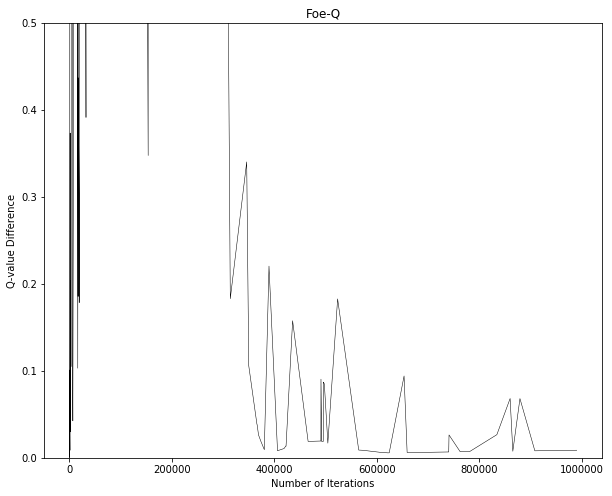

In [10]:
errr[0] = 1

plt.figure('Q-Learning')
plt.clf()
plt.title('Foe-Q')
plt.xlabel('Number of Iterations')
plt.ylabel('Q-value Difference')
plt.ylim(0, 0.5)
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(ind, errr, linestyle='-', color='black', linewidth=0.5)
plt.savefig('FoeQ.png')